In [1]:
using Optim
using ForwardDiff
using FastGaussQuadrature
using QuadGK
using Plots

In [2]:
function gaussian(center, ε)
    function (x)
        return exp(-(ε*(x - center))^2)
    end
end


function pointwise_difference(f, g)
    function (x)
        return f(x) - g(x)
    end
end

function pointwise_square(f)
    function (x)
        return f(x)^2 
    end
end


function l2_distance(f, g)
    integrand = pointwise_square(pointwise_difference(f, g))
    return sqrt(quadgk(integrand, 0, 1)[1])
end

function create_nodes_equidistant(N)
    return collect(range(0, 1, length=N))
end


function create_rbf_basis(nodes, params)
    return [gaussian(nodes[i], params[i]) for i in 1:length(nodes)]
end


function interpolation_matrix(nodes, basis)
    return [bi(xi) for xi in nodes, bi in basis]
end

function load_vector(f, nodes)
    load = [f(xi) for xi in nodes]
    load[1] = load[end] = 0.
    return load
end


function build_function(weights, basis)
    @assert length(weights) == length(basis) "weights and basis vector need to be of same length"
    N = length(weights)
    function (x)
        out = 0.
        for i in 1:N
            out += weights[i] * basis[i](x)
        end
        return out
    end
end

function interpolate(nodes, load_vector, params)
    basis = create_rbf_basis(nodes, params)
    A = interpolation_matrix(nodes, basis)
    weights = A \ load_vector
    return build_function(weights, basis)
end


function optimal_interpolation_parameter(f, nodes)
    N = length(nodes)
    b = load_vector(f, nodes)
    
    function cost(ε)
        f_interp = interpolate(nodes, ε, b)
        return l2_approx_distance(f, f_interp)
    end
    
    ε0 = 10. * ones(N)
    lower = ones(N) * 1e-1
    upper = ones(N)  * Inf
    
    cost_grad!(storage, ε) = ForwardDiff.gradient!(storage, cost, ε)
    
    res = optimize(cost, lower, upper, ε0, Fminbox())
    
    display(res)
    return res
end

optimal_interpolation_parameter (generic function with 1 method)

In [244]:
function gaussian(center, ε)
    function (x)
        return exp(-(ε*(x - center))^2)
    end
end

function bump(center, ε)
    function (x)
        if abs(x - center) < 1. / ε
            return exp(1) * exp(- 1. / (1 - (ε*(x - center))^2))
        end
        return 0.
    end
end

function bump_unscaled(center, ε)
    function (x)
        if abs(x - center) < 1. / ε
            return exp(- 1. / (1 - (ε*(x - center))^2))
        end
        return 0.
    end
end


function pointwise_difference(f, g)
    function (x)
        return f(x) - g(x)
    end
end

function pointwise_square(f)
    function (x)
        return f(x)^2 
    end
end


function l2_norm(f)
    return sqrt(quadgk(x -> f(x)^2, 0, 1)[1])
end


function l2_distance(f, g)
    integrand = pointwise_square(pointwise_difference(f, g))
    return sqrt(quadgk(integrand, 0, 1)[1])
end


function l2_approx_distance(f, g; npoints=1000)
    out = 0.0
    h = 1 / npoints
    for i in 0:npoints-1
        xi = i*h
        out += (f(xi) - g(xi))^2
    end
    return sqrt(out*h)
end


function create_nodes_equidistant(N)
    return collect(range(0, 1, length=N))
end


function create_rbf_basis(nodes, params)
    return [gaussian(nodes[i], params[i]) for i in 1:length(nodes)]
end


function create_bump_basis(nodes, params)
    return [bump(nodes[i], params[i]) for i in 1:length(nodes)]
end

function create_bump_unscaled_basis(nodes, params)
    return [bump_unscaled(nodes[i], params[i]) for i in 1:length(nodes)]
end

function interpolation_matrix(nodes, basis)
    return [bi(xi) for xi in nodes, bi in basis]
end

function load_vector(f, nodes)
    load = [f(xi) for xi in nodes]
    load[1] = load[end] = 0.
    return load
end


function build_function(weights, basis)
    @assert length(weights) == length(basis) "weights and basis vector need to be of same length"
    N = length(weights)
    function (x)
        out = 0.
        for i in 1:N
            out += weights[i] * basis[i](x)
        end
        return out
    end
end

function interpolate(nodes, load_vector, params)
    basis = create_rbf_basis(nodes, params)
    A = interpolation_matrix(nodes, basis)
    weights = A \ load_vector
    return build_function(weights, basis)
end


function optimal_interpolation_parameter(f, nodes)
    N = length(nodes)
    b = load_vector(f, nodes)
    
    function cost(ε)
        f_interp = interpolate(nodes, b, ε)
        return l2_distance(f, f_interp)
    end
    
    ε0 = 10. * ones(N)
    lower = ones(N) * 1e-1
    upper = ones(N)  * Inf
    
    cost_grad!(storage, ε) = ForwardDiff.gradient!(storage, cost, ε)
    
    res = optimize(cost, cost_grad!,  lower, upper, ε0, Fminbox(BFGS()))
    
    display(res)
    return res
end


function optimal_interpolation(f, N)
    
    # Define cost functional
    function cost(x)
        nodes = x[1:N]
        ε = x[N+1:end]
        b = load_vector(f, nodes)
        
        f_interp = interpolate(nodes, b, ε)
        return l2_approx_distance(f, f_interp)
    end
    
    
    # Create initial vector
    nodes0 = create_nodes_equidistant(N)
    ε0 = 10. * ones(N)
    x0 = [nodes0..., ε0...]
    
    
    # Create constraints
    lower_nodes = zeros(N) .- 1e-5
    upper_nodes = ones(N) .+ 1e-5 
    lower_ε = ones(N) * 1e-1
    upper_ε = ones(N)  * Inf
    lower = [lower_nodes..., lower_ε...]
    upper = [upper_nodes..., upper_ε...]
    
    # Start optimizer 
    cost_grad!(storage, x) = ForwardDiff.gradient!(storage, cost, x)
    res = optimize(cost, cost_grad!, lower, upper, x0, Fminbox(BFGS()))
    
    display(res)
    return res
end

optimal_interpolation (generic function with 1 method)

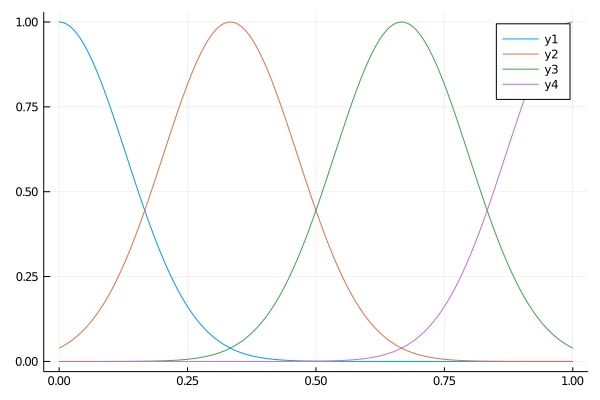

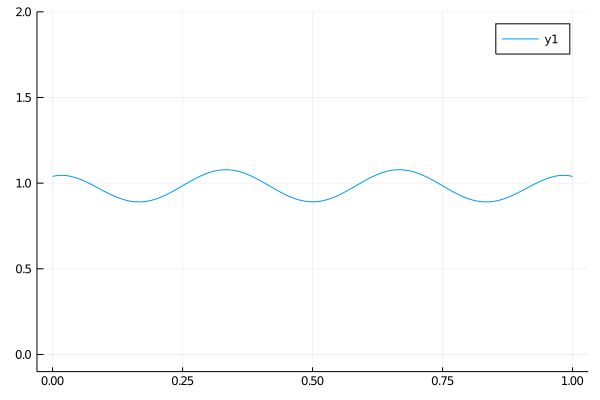

In [270]:
N = 4
h = 1 / (N-1)
nodes = range(0, 1, length=N)
params = ones(N) * (N - 1) * 1.8
basis = create_rbf_basis(nodes, params)

plot()
for bi in basis
    plot!(bi, X)
end

display(plot!())

plot(x -> sum([bi(x) for bi in  basis]), X, ylims=(-0.1, 2.))

display(plot!())

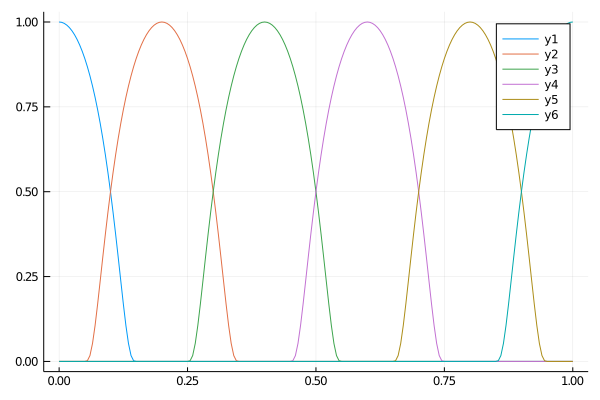

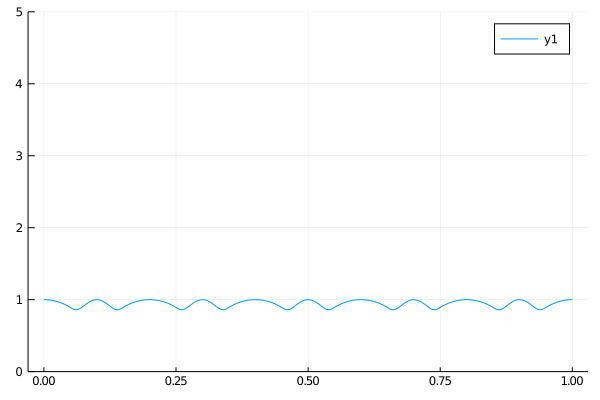

In [375]:
N = 6
nodes = range(0, 1, length=N)
params = ones(N) * (N-1) * 2 * sqrt(log(2)/ (log(2) + 1)) * 1.

basis = create_bump_basis(nodes, params)

plot()
for bi in basis
    plot!(bi, X)
end
display(plot!())
plot(x -> sum([bi(x) for bi in  basis]), X, ylims=(0., 5))

display(plot!())

In [306]:
1 ./ params

6-element Array{Float64,1}:
 0.15629123586717725
 0.15629123586717725
 0.15629123586717725
 0.15629123586717725
 0.15629123586717725
 0.15629123586717725

In [305]:
1 / (N - 1)

0.2

In [251]:
ℯ

ℯ = 2.7182818284590...

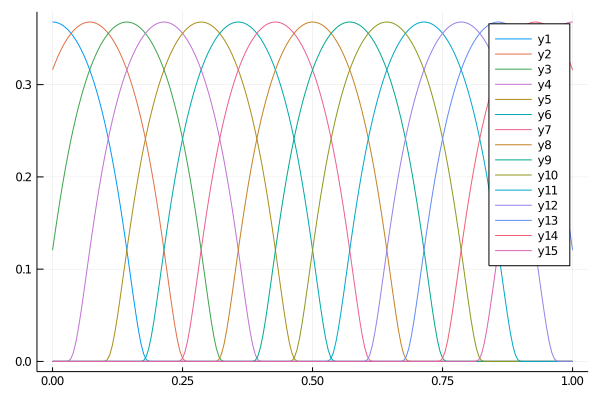

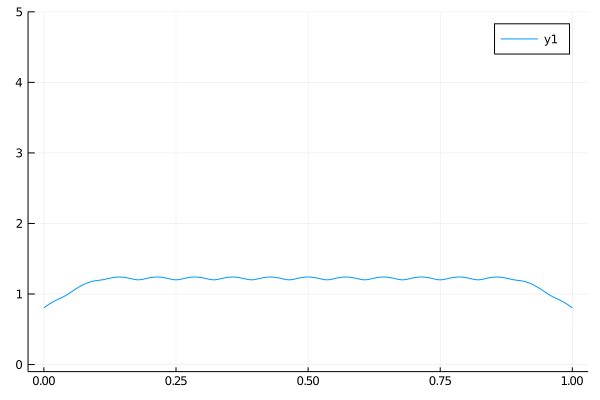

0.0


In [353]:
N = 15
nodes = range(0, 1, length=N)
params = ones(N) * (N-1) * sqrt(log(2 / (ℯ-1)) / (1 + log(2/ (ℯ-1))))
basis = create_bump_unscaled_basis(nodes, params)
println(basis[2](0.5))

plot()
for bi in basis
    plot!(bi, X)
end
display(plot!())
plot(x -> sum([bi(x) for bi in  basis]), X, ylims=(-0.1, 5.))

display(plot!())

In [108]:
F(x) = exp(-(5.0 * (x - 0.75))^2) + exp(-(10.0 * (x - 0.25))^2)
F(x) = 1.



N = 11
params =  (N - 1) * sqrt(log(2)) / 2* ones(N)


nodes = range(0, 1, length=N)
b = load_vector(F, nodes)

basis = create_rbf_basis(nodes, params)
A = interpolation_matrix(nodes, basis)
b = load_vector(F, nodes)

weights = A \ b

11-element Array{Float64,1}:
  -26.462526772133472
   80.78299352237936
 -141.13679418188156
  192.0728537331877
 -223.35712466782414
  234.50577775151064
 -223.35712466785048
  192.07285373322756
 -141.13679418191768
   80.78299352240059
  -26.462526772140002

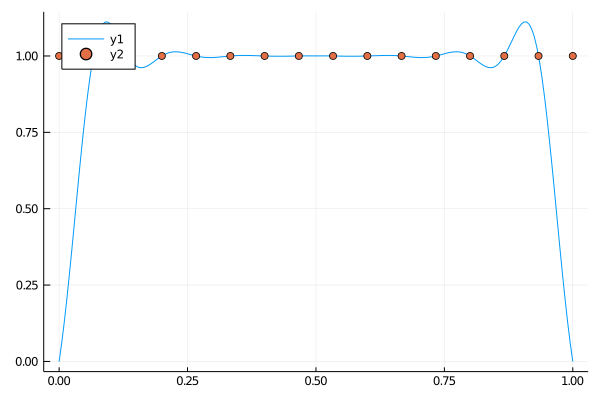

In [382]:
N = 16
test(x) = 1.

param =  ones(N) * (N - 1) * 1.


nodes = range(0, 1, length=N)
basis = create_bump_basis(nodes, param)
b = load_vector(test, nodes)

F_gaussian = interpolate(nodes, b, param)

plot(F_gaussian, X, legend=:topleft)
scatter!(nodes, test.(nodes))

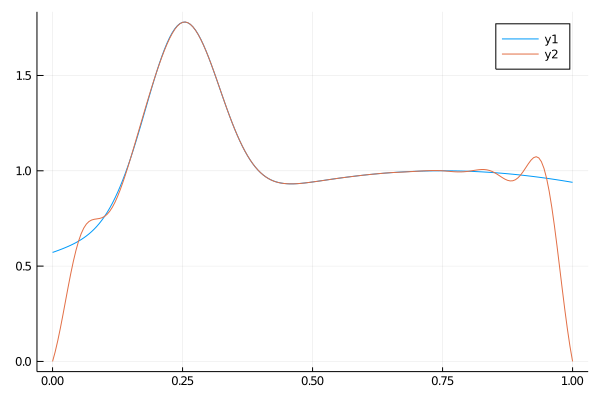

21-element Array{Float64,1}:
 0.0
 1.7150782633137505
 2.0680837082552483
 2.896480879304951
 4.125724630050814
 4.83528184507172
 4.336984041807254
 3.3163669767810924
 2.6913847817984764
 2.5341096017526805
 2.5588369764621084
 2.61203193605102
 2.65781642811365
 2.691234778251583
 2.711494615807637
 2.7182818284967967
 2.7114946114443725
 2.691234472349263
 2.6578034208159957
 2.6116964734231174
 0.0

In [370]:
N = 21
F(x) = exp(-(1.0 * (x - 0.75))^2) + exp(-(10.0 * (x - 0.25))^2)
# F(x) = 1.

nodes = range(0, 1, length=N)
# params =  ones(N) * (N - 1) *1.0 # Gaussian
params =  (N - 1) * sqrt(log(2)) / 2 * ones(N) # Bump
params =  ones(N) * (N - 1) * 1.  # unscaled bump

params = ones(N) * (N-1)


b = load_vector(F, nodes)
# b = [F(xi) for xi in nodes]

F_interp = interpolate(nodes, b, params)


X = 0:0.005:1
plot(F, X)
display(plot!(F_interp, X))


basis = create_bump_unscaled_basis(nodes, params)
A = interpolation_matrix(nodes, basis)
b = load_vector(F, nodes)

weights = A \ b

In [4]:
F(x) = exp(-(5.0 * (x - 0.75))^2) + exp(-(10.0 * (x - 0.25))^2)

N = 4
nodes = range(0, 1, length=N)
b = load_vector(F, nodes)

ε0 = 20. * ones(N)
F_interp = interpolate(nodes, b, ε0)


res_param = optimal_interpolation_parameter(F, nodes)
F_optimal_param = interpolate(nodes, b, res_param.minimizer)

res_full = optimal_interpolation(F, N)
nodes_opt = res_full.minimizer[1:N]
b_opt = load_vector(F, nodes_opt)
F_optimal_param = interpolate(nodes, b, res_full.minimizer)

 * Status: success

 * Candidate solution
    Final objective value:     2.357770e-01

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 1.64e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.38e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.88e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    3
    f(x) calls:    172
    ∇f(x) calls:   172


 * Status: success

 * Candidate solution
    Final objective value:     2.610125e-16

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.50e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    6
    f(x) calls:    1273
    ∇f(x) calls:   1273


#28 (generic function with 1 method)

In [371]:
X = 0:0.005:1
plot(F, X)
plot!(F_interp, X)
plot!(F_optimal, X)
plot!(F_optimal_param, X)

LoadError: UndefVarError: F_optimal not defined